ARIMA Model

In [1]:
import pandas as pd
import matplotlib.pyplot as plt
from statsmodels.tsa.arima.model import ARIMA
from math import sqrt
from sklearn.metrics import mean_squared_error

In [2]:
df = pd.read_csv("data.csv", usecols=["Close"])
values = df.Close.values

In [3]:
split_index = int(len(df)*0.7)
train, test = values[0:split_index], values[split_index:len(values)]

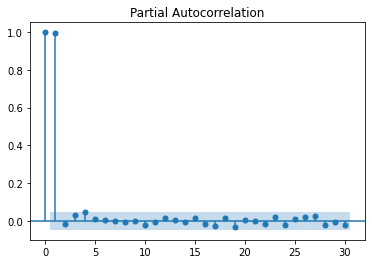

In [4]:
# use partial autocorrelation plot to determine order of autoregressive model
from statsmodels.graphics.tsaplots import plot_pacf
pacf = plot_pacf(df["Close"], lags=30)

In [5]:
history = [x for x in train]
predictions = []

In [6]:
# Do rolling forecast, taking into account each new fit
model = ARIMA(history, order=(1, 1, 1))
model_fit = model.fit()

for i in range(len(test)):
    model = ARIMA(history, order=(1, 1, 1))
    model_fit = model.fit()
    pred = model_fit.forecast()[0]
    predictions.append(pred)
    history.append(test[i])

In [7]:
# Calculate error of ARIMA algorithm
rmse_ARIMA = sqrt(mean_squared_error(test, predictions))
print("RMSE for ARIMA: {}".format(rmse_ARIMA))

RMSE for ARIMA: 482.33065746516024


In [8]:
# Predict close price and output as csv
result_df = pd.read_csv("sample_submission.csv")

results = model_fit.predict(start=len(df), end=len(df)+len(result_df)-1)
result_df["Predicted"] = results
result_df.to_csv("predictions_ARIMA.csv", index=False)

AutoRegressive Model

In [9]:
# Fit autoregression model
from statsmodels.tsa.ar_model import AutoReg as AR

model_AR = AR(train, lags=1)
model_AR_fit = model_AR.fit()

c:\users\bryan\appdata\local\programs\python\python39\lib\site-packages\statsmodels\tsa\ar_model.py:248: FutureWarning: The parameter names will change after 0.12 is released. Set old_names to False to use the new names now. Set old_names to True to use the old names. 
  warnings.warn(


In [10]:
# Test Autoregression model
predictions_AR = model_AR_fit.predict(start=len(train), end=len(train)+len(test)-1)
rmse_AR = sqrt(mean_squared_error(test, predictions_AR))
print("RMSE for AutoRegressive Model: {}".format(rmse_AR))

RMSE for AutoRegressive Model: 6181.7386291563835


In [11]:
# Predict close price and output as csv
results_AR = model_AR_fit.predict(start=len(df), end=len(train)+len(test)+len(result_df)-1)
result_df["Predicted"] = results_AR
result_df.to_csv("predictions_AR.csv", index=False)

LSTM Model

In [12]:
from sklearn.preprocessing import MinMaxScaler
from keras.models import Sequential, load_model
from keras.layers import LSTM, Dense, Dropout
import numpy as np

In [13]:
df = pd.read_csv("data.csv")["Close"].values
df = df.reshape(-1,1)

In [14]:
training_set = np.array(df[:int(df.shape[0]*0.8)])
testing_set = np.array(df[int(df.shape[0]*0.8):])

In [15]:
# Scale data
scaler = MinMaxScaler(feature_range=(0,1))
train_set = scaler.fit_transform(training_set)
test_set = scaler.fit_transform(testing_set)

In [16]:
def create_dataset(df):
    x, y = list(), list()
    for i in range(1, len(df)):
        x.append(df[i-1, 0])  # append previous price
        y.append(df[i, 0]) # append current price
        
    x = np.array(x)
    y = np.array(y)
    
    return x, y

In [17]:
x_train, y_train = create_dataset(train_set)
x_test, y_test = create_dataset(test_set)

In [18]:
# Reshape data into 3D array to use in LSTM layer
x_train = np.reshape(x_train, (x_train.shape[0], 1, 1))
x_test = np.reshape(x_test, (x_test.shape[0], 1, 1))

In [19]:
# Build model
model = Sequential()
model.add(LSTM(units=96, return_sequences=True, input_shape=(x_train.shape[0], 1)))
model.add(Dropout(0.2))
model.add(LSTM(units=96,return_sequences=True))
model.add(Dropout(0.2))
model.add(LSTM(units=96,return_sequences=True))
model.add(Dropout(0.2))
model.add(LSTM(units=96))
model.add(Dropout(0.2))
model.add(Dense(units=1))

In [20]:
# Compile model
model.compile(loss='mean_squared_error', optimizer='adam')

In [21]:
# Fit and save model
model.fit(x_train, y_train, epochs=50, batch_size=32)
model.save('predictions.h5')

Epoch 1/50
41/41 [==============================] - 6s 6ms/step - loss: 0.2092
Epoch 2/50
41/41 [==============================] - 0s 6ms/step - loss: 0.0300
Epoch 3/50
41/41 [==============================] - 0s 6ms/step - loss: 0.0142
Epoch 4/50
41/41 [==============================] - 0s 6ms/step - loss: 0.0065
Epoch 5/50
41/41 [==============================] - 0s 7ms/step - loss: 0.0054
Epoch 6/50
41/41 [==============================] - 0s 6ms/step - loss: 0.0052
Epoch 7/50
41/41 [==============================] - 0s 6ms/step - loss: 0.0046
Epoch 8/50
41/41 [==============================] - 0s 7ms/step - loss: 0.0041
Epoch 9/50
41/41 [==============================] - 0s 9ms/step - loss: 0.0039
Epoch 10/50
41/41 [==============================] - 0s 8ms/step - loss: 0.0037
Epoch 11/50
41/41 [==============================] - 0s 7ms/step - loss: 0.0040
Epoch 12/50
41/41 [==============================] - 0s 8ms/step - loss: 0.0034
Epoch 13/50
41/41 [==============================

In [22]:
# Load model
model = load_model('predictions.h5')

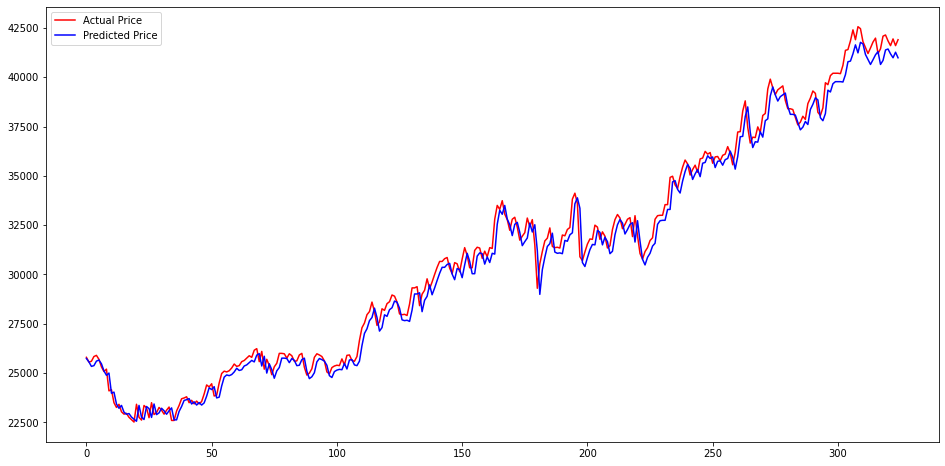

In [23]:
# Visualise actual vs predicted prices
predictions = model.predict(x_test)
predictions = scaler.inverse_transform(predictions)
y_test_scaled = scaler.inverse_transform(y_test.reshape(-1,1))

fig, ax = plt.subplots(figsize=(16,8))
ax.plot(y_test_scaled, color='red', label='Actual Price')
plt.plot(predictions, color='blue', label='Predicted Price')
plt.legend()

In [24]:
history = testing_set

for i in range(len(result_df)):
    scaled_history = scaler.fit_transform(history)
    curr = np.reshape(scaled_history[-1], (1, 1, 1))
    pred = model.predict(curr)
    pred = scaler.inverse_transform(pred)
    history = np.append(history, pred, axis=0)

In [25]:
predicted_prices = list()

for i in range(len(result_df),0,-1):
    predicted_prices.append(history[-i][0])

In [26]:
result_df["Predicted"] = predicted_prices
result_df.to_csv("predictions_LSTM.csv", index=False)

In [27]:
rmse_LSTM = sqrt(mean_squared_error(predictions, y_test_scaled))
print("RMSE for LSTM Model: {}".format(rmse_LSTM))

RMSE for LSTM Model: 601.529591976521
